Carga de los paquetes:

In [1]:
from timeit import default_timer as timer
from datetime import timedelta

import time
import warnings
from ripser import ripser
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
from persim import plot_diagrams
import persim
import glob
from numpy import asarray
from PIL import Image
import os
import random
import math

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
from sklearn.datasets import load_breast_cancer

from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
import warnings

import umap

import pandas as pd

from scipy.spatial.distance import pdist, squareform
import stablerank.srank as sr
from stablerank.rtorf import Density

warnings.filterwarnings('ignore')

Tomo el dataset:

In [2]:
!wget https://unirioja-my.sharepoint.com/:x:/g/personal/adines_unirioja_es/EacFPSkXU9NMiMaWO_a9bfoB1f4h_3ibFIUvmF_8f7tNXA?download=1 -O ionosphere.csv

--2024-03-13 10:08:19--  https://unirioja-my.sharepoint.com/:x:/g/personal/adines_unirioja_es/EacFPSkXU9NMiMaWO_a9bfoB1f4h_3ibFIUvmF_8f7tNXA?download=1
Resolving unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)... 13.107.136.10, 13.107.138.10
Connecting to unirioja-my.sharepoint.com (unirioja-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/adines_unirioja_es/Documents/ionosphere.csv?ga=1 [following]
--2024-03-13 10:08:20--  https://unirioja-my.sharepoint.com/personal/adines_unirioja_es/Documents/ionosphere.csv?ga=1
Reusing existing connection to unirioja-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 76467 (75K) [application/octet-stream]
Saving to: 'ionosphere.csv'

     0K .......... .......... .......... .......... .......... 66%  358K 0s
    50K .......... .......... ....                            100%  180K=0,3s

2024-03-13 10:08:20 (270 KB/s) - 'ionosphere.csv' saved [

In [3]:
def load_prima():
  df=pd.read_csv("ionosphere.csv", sep=',',header=None)
  df1 = df.iloc[:,:-1]
  df2=df.iloc[:,-1]
  return df1.values,df2.values

In [4]:
def preparar_dataset(data,target,n_labeled=25):
  unos=np.where(target==1)[0]
  ceros=np.where(target==0)[0]

  datos_uno=np.array(data)[unos]
  datos_cero=np.array(data)[ceros]

  unos_valid=int((len(list(unos))-n_labeled)*0.2)
  ceros_valid=int((len(list(ceros))-n_labeled)*0.2)

  random.seed(15)
  indices_unos=random.sample(list(unos),n_labeled+unos_valid)

  random.seed(10)
  indices_ceros=random.sample(list(ceros),n_labeled+ceros_valid)


  puntos_unos=np.array(data)[indices_unos[0:n_labeled]]
  puntos_ceros=np.array(data)[indices_ceros[0:n_labeled]]

  puntos_unos_valid=np.array(data)[indices_unos[n_labeled:]]
  puntos_ceros_valid=np.array(data)[indices_ceros[n_labeled:]]

  unlabeled_unos=list(set(unos)-set(indices_unos))
  unlabeled_ceros=list(set(ceros)-set(indices_ceros))
  unlabeled=unlabeled_unos+unlabeled_ceros
  X_unlabeled_unos=np.array(data)[unlabeled_unos]
  X_unlabeled_ceros=np.array(data)[unlabeled_ceros]

  return (puntos_ceros,puntos_unos,X_unlabeled_ceros,X_unlabeled_unos,puntos_ceros_valid,puntos_unos_valid)

## Stable rank sin umbral

Seguimos el mismo procedimiento que Inés et al, con la diferencia de que en vez de calcular los diagramas de persistencia, calculamos el stable rank. En este caso, la distancia se refleja en la elección del contour. El clustering method influye sólo a la hora de calcular el diagrama de persistencia. 

In [5]:
def analizar_punto_stable_rank(punto, puntos_ceros, puntos_unos, srank_ceros, srank_unos, hom_deg=0, contour=sr.standard_contour(), clustering_method="single", w_p=inf, w_q=1, reduced=True, p=2):
    
    d_ceros_mod = sr.Distance(squareform(pdist(np.array([punto.tolist()]+puntos_ceros.tolist()), "euclidean")))
    d_unos_mod = sr.Distance(squareform(pdist(np.array([punto.tolist()]+puntos_unos.tolist()), "euclidean")))
    if hom_deg==0:
        srank_ceros_mod=d_ceros_mod.get_h0sr(clustering_method = clustering_method, contour=contour, w_p=w_p, w_q=w_q, reduced=reduced)
        srank_unos_mod=d_unos_mod.get_h0sr(clustering_method=clustering_method, contour=contour, w_p=w_p, w_q=w_q, reduced=reduced)
    elif hom_deg==1:
        srank_ceros_mod=sr.bc_to_sr(d_ceros_mod.get_bc(sample=None, maxdim=1))
        srank_unos_mod=sr.bc_to_sr(d_unos_mod.get_bc(sample=None, maxdim=1))
        
    
    distance_cero=srank_ceros.lp_distance(srank_ceros_mod,p)
    distance_uno=srank_unos.lp_distance(srank_unos_mod,p)
    
    clase=-1
    if distance_cero>distance_uno:
        clase=1
    else:
        clase=0
    return clase

## Stable rank con umbral

In [6]:
def analizar_punto_stable_rank_th(punto,puntos_ceros,puntos_unos,srank_ceros,srank_unos, hom_deg=0, contour=sr.standard_contour(),clustering_method="single",w_p=inf,w_q=1,reduced=True,p=2,th=0.8):
    d_ceros_mod = sr.Distance(squareform(pdist(np.array([punto.tolist()]+puntos_ceros.tolist()), "euclidean")))
    d_unos_mod = sr.Distance(squareform(pdist(np.array([punto.tolist()]+puntos_unos.tolist()), "euclidean")))
    if hom_deg==0:
        srank_ceros_mod=d_ceros_mod.get_h0sr(clustering_method = clustering_method, contour=contour, w_p=w_p, w_q=w_q, reduced=reduced)
        srank_unos_mod=d_unos_mod.get_h0sr(clustering_method=clustering_method, contour=contour, w_p=w_p, w_q=w_q, reduced=reduced)
    elif hom_deg==1:
        srank_ceros_mod=sr.bc_to_sr(d_ceros_mod.get_bc(sample=None, maxdim=1))
        srank_unos_mod=sr.bc_to_sr(d_unos_mod.get_bc(sample=None, maxdim=1))
    
    distance_cero=srank_ceros.lp_distance(srank_ceros_mod,p)
    distance_uno=srank_unos.lp_distance(srank_unos_mod,p)
    
    distancia=distance_cero+distance_uno
    if max(distance_cero/distancia,distance_uno/distancia)<th:
        clase=-1
    elif distance_cero>distance_uno:
        clase=1
    else:
        clase=0
    return clase

## K-nn sin umbral

Primero, presentamos un programa calculándolos para los puntos ya etiquetados, de manera que obtenemos una serie de cuatro stable ranks (según perspectiva y grado homológico) para cada punto, que lo caracteriza.

In [7]:
def calcular_sranks_muestra(puntos_ceros,puntos_unos,sd_distribution,number_instances,sample_size_percentage, contour=sr.standard_contour(),clustering_method="single",w_p=inf,w_q=1,reduced=True):
    
    n_ceros=len(puntos_ceros)
    n_unos=len(puntos_unos)
    distribution=sr.get_distribution(name="norm", loc=0, scale=sd_distribution)
    sample_size=math.trunc(sample_size_percentage*len(puntos_ceros)/100)
    
    ceros_distances=squareform(pdist(puntos_ceros,"euclidean"))
    distance_ceros=sr.Distance(ceros_distances)
    
    unos_distances=squareform(pdist(puntos_unos,"euclidean"))
    distance_unos=sr.Distance(unos_distances)
    
    ceros_wr_unos_distances=[]
    for point in puntos_unos:
        d_ceros_mod = squareform(pdist(np.array([point.tolist()]+puntos_ceros.tolist()), "euclidean"))
        l=d_ceros_mod[0].tolist()
        l.pop(0)
        ceros_wr_unos_distances.append(l)
    ceros_wr_unos_distances=np.array(ceros_wr_unos_distances)
    
    unos_wr_ceros_distances=[]
    for point in puntos_ceros:
        d_unos_mod = squareform(pdist(np.array([point.tolist()]+puntos_unos.tolist()), "euclidean"))
        l=d_unos_mod[0].tolist()
        l.pop(0)
        unos_wr_ceros_distances.append(l)
    unos_wr_ceros_distances=np.array(unos_wr_ceros_distances)
    
    sranks_puntos_ceros=[[0 for x in range(4)] for y in range(n_ceros)]
    sranks_puntos_unos=[[0 for x in range(4)] for y in range(n_ceros)]
    
    for i in range(n_ceros):
        p=distribution(ceros_distances[i].tolist())
        s=sr.get_sample(number_instances,sample_size,p)
        sranks_puntos_ceros[i][0] = distance_ceros.get_h0sr(sample=s, contour=sr.standard_contour(), clustering_method="single", w_p=inf, w_q=1, reduced=True)
        b = distance_ceros.get_bc(sample=s, maxdim=1)
        sranks_puntos_ceros[i][1] = sr.bc_to_sr(b,degree="H1")
        
        p=distribution(ceros_wr_unos_distances[i].tolist())
        s=sr.get_sample(number_instances,sample_size,p)
        sranks_puntos_ceros[i][2] = distance_ceros.get_h0sr(sample=s, contour=sr.standard_contour(), clustering_method="single", w_p=inf, w_q=1, reduced=True)
        b = distance_ceros.get_bc(sample=s, maxdim=1)
        sranks_puntos_ceros[i][3] = sr.bc_to_sr(b,degree="H1")
        
        p=distribution(unos_distances[i].tolist())
        s=sr.get_sample(number_instances,sample_size,p)
        sranks_puntos_unos[i][0] = distance_unos.get_h0sr(sample=s, contour=sr.standard_contour(), clustering_method="single", w_p=inf, w_q=1, reduced=True)
        b = distance_unos.get_bc(sample=s, maxdim=1)
        sranks_puntos_unos[i][1] = sr.bc_to_sr(b,degree="H1")
        
        p=distribution(unos_wr_ceros_distances[i].tolist())
        s=sr.get_sample(number_instances,sample_size,p)
        sranks_puntos_unos[i][2] = distance_ceros.get_h0sr(sample=s, contour=sr.standard_contour(), clustering_method="single", w_p=inf, w_q=1, reduced=True)
        b = distance_unos.get_bc(sample=s, maxdim=1)
        sranks_puntos_unos[i][3] = sr.bc_to_sr(b,degree="H1")
        
    
    return (sranks_puntos_ceros, sranks_puntos_unos)

Hacemos lo propio con los stable ranks del punto a etiquetar.

In [8]:
def calcular_sranks_punto_v_muestra(punto,puntos_ceros,puntos_unos,sd_distribution,number_instances, sample_size_percentage, contour=sr.standard_contour(), clustering_method="single",w_p=inf,w_q=1,reduced=True):
    
    n_ceros=len(puntos_ceros)
    n_unos=len(puntos_unos)
    distribution=sr.get_distribution(name="norm", loc=0, scale=sd_distribution)
    sample_size=math.trunc(sample_size_percentage*len(puntos_ceros)/100)
    
    ceros_distances=squareform(pdist(puntos_ceros,"euclidean"))
    distance_ceros=sr.Distance(ceros_distances)
    
    unos_distances=squareform(pdist(puntos_unos,"euclidean"))
    distance_unos=sr.Distance(unos_distances)
    
    d_ceros_mod = squareform(pdist(np.array([punto.tolist()]+puntos_ceros.tolist()), "euclidean"))
    l=d_ceros_mod[0].tolist()
    l.pop(0)
    ceros_wr_punto_distances = l
    
    d_unos_mod = squareform(pdist(np.array([punto.tolist()]+puntos_unos.tolist()), "euclidean"))
    l=d_unos_mod[0].tolist()
    l.pop(0)
    unos_wr_punto_distances = l
    
    sranks_punto=[]
    
    p = distribution(ceros_wr_punto_distances)
    s = sr.get_sample(number_instances, sample_size, p)
    sranks_punto.append( distance_ceros.get_h0sr(sample=s,contour=sr.standard_contour(),clustering_method="single",w_p=inf,w_q=1,reduced=True))
    b = distance_ceros.get_bc(sample=s, maxdim=1)
    sranks_punto.append(sr.bc_to_sr(b,degree="H1"))
    p = distribution(unos_wr_punto_distances)
    s = sr.get_sample(number_instances, sample_size, p)
    sranks_punto.append(distance_unos.get_h0sr(sample=s,contour=sr.standard_contour(),clustering_method="single",w_p=inf,w_q=1,reduced=True))
    b = distance_unos.get_bc(sample=s, maxdim=1)
    sranks_punto.append(sr.bc_to_sr(b,degree="H1"))
        

    
    return (sranks_punto)

Ahora lo que tenemos que hacer es hacer lo propio para el punto, de manera que obtengamos un invariante que podamos comparar con los que ya tenemos, y así etiquetar.

En este caso, comparamos los stable ranks de nuestro punto con los de los ya etiquetados. Tomamos un k y asignamos la etiqueta que tenga más miembros entre los k más cercanos.

In [32]:
def analizar_punto_stable_rank_relative(punto,puntos_ceros,puntos_unos, sranks_puntos_ceros, sranks_puntos_unos, sd_distribution, number_instances, sample_size_percentage, contour=sr.standard_contour(), clustering_method="single", w_p=inf,w_q=1,reduced=True,p=2,th=0,k=1):
    sranks_punto=calcular_sranks_punto_v_muestra(punto,puntos_ceros,puntos_unos,sd_distribution,number_instances,sample_size_percentage, contour=sr.standard_contour(),clustering_method="single",w_p=inf,w_q=1,reduced=True)


    distancias = []
    n_labeled=len(puntos_ceros)
    
    
    for i in range(n_labeled):
        distancias.append([abs(sranks_puntos_ceros[i][0].lp_distance(sranks_punto[0]))+ abs(sranks_puntos_ceros[i][1].lp_distance(sranks_punto[1]))+ abs(sranks_puntos_unos[i][2].lp_distance(sranks_punto[0]))+ abs(sranks_puntos_unos[i][3].lp_distance(sranks_punto[1])),0])
        distancias.append([abs(sranks_puntos_unos[i][0].lp_distance(sranks_punto[2]))+ abs(sranks_puntos_unos[i][1].lp_distance(sranks_punto[3]))+ abs(sranks_puntos_ceros[i][2].lp_distance(sranks_punto[2]))+ abs(sranks_puntos_ceros[i][3].lp_distance(sranks_punto[3])),1])

    distancias=sorted(distancias, key=lambda x: x[0])
    
    e=0
    for i in range(k):
        e=e+distancias[i][1]

    if e/k>0.5:
        clase=1
        sranks_punto[0].plot(color="green")
        sranks_punto[1].plot(color="green")
    else:
        clase=0
        sranks_punto[0].plot(color="green")
        sranks_punto[1].plot(color="green")
    return clase

## K-nn con umbral

In [22]:
def analizar_punto_stable_rank_relative_th(punto,puntos_ceros,puntos_unos, sranks_puntos_ceros, sranks_puntos_unos, sd_distribution, number_instances, sample_size_percentage, contour=sr.standard_contour(), clustering_method="single",w_p=inf,w_q=1,reduced=True,p=2,th=0,k=1):
        
        
                        
    sranks_punto=calcular_sranks_punto_v_muestra(punto, puntos_ceros,puntos_unos, sd_distribution, number_instances, sample_size_percentage, contour=sr.standard_contour(), clustering_method="single",w_p=inf,w_q=1,reduced=True)
    

    distancias = []
    n_labeled=len(puntos_ceros)
    
    for i in range(n_labeled):
        distancias.append([abs(sranks_puntos_ceros[i][0].lp_distance(sranks_punto[0],p=p))+ abs(sranks_puntos_ceros[i][1].lp_distance(sranks_punto[1],p=p))+ abs(sranks_puntos_unos[i][2].lp_distance(sranks_punto[2],p=p))+ abs(sranks_puntos_unos[i][3].lp_distance(sranks_punto[3],p=p)),0])
        distancias.append([abs(sranks_puntos_unos[i][0].lp_distance(sranks_punto[2],p=p))+ abs(sranks_puntos_unos[i][1].lp_distance(sranks_punto[3],p=p))+ abs(sranks_puntos_ceros[i][2].lp_distance(sranks_punto[0],p=p))+ abs(sranks_puntos_ceros[i][3].lp_distance(sranks_punto[1],p=p)),1])
   
    

    
    distancias=sorted(distancias, key=lambda x: x[0])
    
    e=0
    distance_cero=0
    distance_uno=0
    for i in range(k):
        e=e+distancias[i][1]
        if distancias[i][1]==0:
            distance_cero=distance_cero+distancias[i][0]
        elif distancias[i][1]==1:
            distance_uno=distance_uno+distancias[i][0]

    distancia=distance_cero + distance_uno
    clase=-1
    if e==0:
        clase=0
    elif e==k:
        clase=1
    elif max(distance_cero/distancia,distance_uno/distancia)<th:
        clase=-1
    elif e/k>0.5:
        clase=1
    else:
        clase=0
        
    return clase

 ## Función para analizar puntos

In [11]:
def analizar_puntos(func,data,target,sd_distribution,number_instances,sample_size_percentage, contour=sr.standard_contour(), w_p=inf,w_q=1,reduced=True,p=2,th=0,k=1,clustering_method="single",reduccion=False):
    (puntos_ceros,puntos_unos,X_unlabeled_ceros,X_unlabeled_unos,X_unlabeled_ceros_valid, X_unlabeled_unos_valid)=preparar_dataset(data,target)
    embedding=data
    if reduccion==True:
        embedding=umap.UMAP(random_state=75).fit_transform(data)
    (puntos_ceros_umap,puntos_unos_umap,X_unlabeled_ceros_umap,X_unlabeled_unos_umap,X_unlabeled_ceros_valid_umap,X_unlabeled_unos_valid_umap)=preparar_dataset(embedding,target)


    bien=0
    mal=0
    dudoso=0

    puntos_ceros_final=puntos_ceros.tolist()
    puntos_unos_final=puntos_unos.tolist()
    puntos_dudosos_final=[]

    (sranks_puntos_ceros,sranks_puntos_unos)=calcular_sranks_muestra(puntos_ceros_umap, puntos_unos_umap, sd_distribution, number_instances, sample_size_percentage, contour, clustering_method, w_p, w_q, reduced)
    
    for i in range(len(puntos_ceros)):
        sranks_puntos_ceros[i][2].plot(color="red")
        sranks_puntos_ceros[i][3].plot(color="red")
        sranks_puntos_unos[i][2].plot(color="blue")
        sranks_puntos_unos[i][3].plot(color="blue")
    

    for i,punto in enumerate(X_unlabeled_unos_umap):
        clase= func(punto,puntos_ceros_umap,puntos_unos_umap,sranks_puntos_ceros,sranks_puntos_unos,sd_distribution,number_instances,sample_size_percentage,contour,clustering_method,w_p,w_q,reduced,p,th,k)
        if clase==1:
          bien=bien+1
          puntos_unos_final.append(X_unlabeled_unos[i])
        elif clase==0:
          mal=mal+1
          puntos_ceros_final.append(X_unlabeled_unos[i])
        else:
          dudoso=dudoso+1
          puntos_dudosos_final.append(X_unlabeled_unos[i])



    for i,punto in enumerate(X_unlabeled_ceros_umap):
        clase= func(punto,puntos_ceros_umap,puntos_unos_umap, sranks_puntos_ceros, sranks_puntos_unos, sd_distribution,number_instances,sample_size_percentage,contour,clustering_method,w_p,w_q,reduced,p,th,k)
        if clase==1:
          mal=mal+1
          puntos_unos_final.append(X_unlabeled_ceros[i])
        elif clase==0:
          bien=bien+1
          puntos_ceros_final.append(X_unlabeled_ceros[i])
        else:
          dudoso=dudoso+1
          puntos_dudosos_final.append(X_unlabeled_ceros[i])

    comprobar_accuracy(np.array(puntos_ceros_final),np.array(puntos_unos_final),X_unlabeled_ceros_valid,X_unlabeled_unos_valid)

    return (bien, mal,dudoso,np.array(puntos_ceros_final),np.array(puntos_unos_final),np.array(puntos_dudosos_final))

## Métodos auxiliares para mostrar resultados

Calcular precisión

In [12]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def comprobar_accuracy(puntos_ceros_final,puntos_unos_final,X_unlabeled_ceros_valid,X_unlabeled_unos_valid):
    datos=np.concatenate((puntos_ceros_final,puntos_unos_final),axis=0)
    labels=np.concatenate((np.zeros(puntos_ceros_final.shape[0]),np.ones(puntos_unos_final.shape[0])))

    modelSVMLineal = SVC(kernel="linear",probability=True,random_state=90)
    modelSVMLineal.fit(datos, labels)

    mal=np.count_nonzero(modelSVMLineal.predict(X_unlabeled_ceros_valid)!=0)
    mal=mal+np.count_nonzero(modelSVMLineal.predict(X_unlabeled_unos_valid)!=1)
    total=X_unlabeled_ceros_valid.shape[0]+X_unlabeled_unos_valid.shape[0]
    print("--------------Clasificador SVM--------------")
    resumen(total-mal,mal,0)
    print("")


    # datos=np.concatenate((puntos_ceros_final,puntos_unos_final),axis=0)
    # labels=np.concatenate((np.zeros(puntos_ceros_final.shape[0]),np.ones(puntos_unos_final.shape[0])))

    modelRandomForest = RandomForestClassifier(random_state=90)
    modelRandomForest.fit(datos, labels)

    mal=np.count_nonzero(modelRandomForest.predict(X_unlabeled_ceros_valid)!=0)
    mal=mal+np.count_nonzero(modelRandomForest.predict(X_unlabeled_unos_valid)!=1)
    total=X_unlabeled_ceros_valid.shape[0]+X_unlabeled_unos_valid.shape[0]
    print("-------------- Clasificador Random Forest--------------")
    resumen(total-mal,mal,0)
    print("")

Resumen de resultados

In [13]:
def resumen(bien,mal,dudosos):
  print('-----------------RESUMEN------------------')
  print('Bien anotados '+str(bien))
  print('Mal anotados '+str(mal))
  print('Sin anotar '+str(dudosos))
  print('')
  if bien+mal!=0:
    print('Porcentaje correcto '+str(bien/(bien+mal)))
  else:
    print('Porcentaje correcto 0')
  print('Porcentaje anotado '+str((bien+mal)/(bien+mal+dudosos)))

## Ejecución

Construyo:

 - Un vector con todos los contornos
 - Un vector con todas las desviaciones típicas
 - Un vector para todos los k (desde 1 hasta 5)
 - Ejecuto para cada umbral

### Vector con todos los contornos
Cojo el dominio en función del tamaño de los datos, y voy variando el valor en los intervalos en función de varios valores fijos (es fuerza bruta, no sé hacerlo de otra manera)

In [14]:
(data,target) = load_prima()

l1=min(data[:,0])
l2=min(data[:,1])
l3=max(data[:,0])
l4=max(data[:,1])

max_dom=((l3-l1)/2+(l4-l2)/2)/4

Contour functions:

In [15]:
contours=[]
dom=[0,1/4*max_dom,2/4*max_dom,3/4*max_dom,4/4*max_dom]
values=[0-1/2*max_dom,1/4*max_dom-1/2*max_dom,2/4*max_dom-1/2*max_dom,3/4*max_dom-1/2*max_dom,4/4*max_dom-1/2*max_dom]

for i1 in values:
    for i2 in values:
        for i3 in values:
            for i4 in values:
                for i5 in values:
                        contours.append(sr.get_contour(Density([dom,[i1,i2,i3,i4,i5]]),"dist",inf))
                        contours.append(sr.get_contour(Density([dom,[i1,i2,i3,i4,i5]]),"area",inf))

Standard deviations:

In [16]:
s1=((l3-l1)/2+(l4-l2)/2)/2
s1
s2=s1/2
s3=1.5*s1
s4=2*s1
s5=0.1

sds=[s1,s2,s3,s4,s5]

number_instances=50
sample_size_percentage=40

## Sin umbral

--------------Clasificador SVM--------------
-----------------RESUMEN------------------
Bien anotados 24
Mal anotados 36
Sin anotar 0

Porcentaje correcto 0.4
Porcentaje anotado 1.0

-------------- Clasificador Random Forest--------------
-----------------RESUMEN------------------
Bien anotados 24
Mal anotados 36
Sin anotar 0

Porcentaje correcto 0.4
Porcentaje anotado 1.0

-----------------RESUMEN------------------
Bien anotados 101
Mal anotados 140
Sin anotar 0

Porcentaje correcto 0.4190871369294606
Porcentaje anotado 1.0


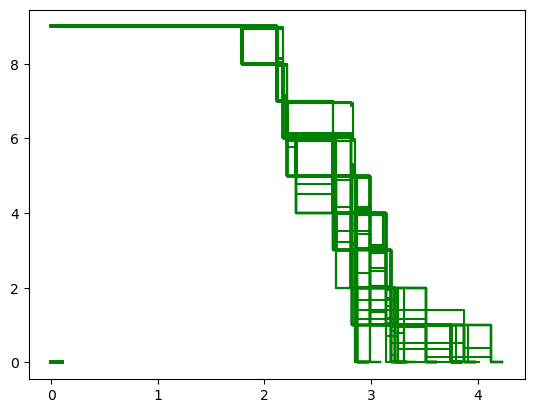

In [34]:
(bien,mal,dudoso,pcero,puno,pdudoso)= analizar_puntos(analizar_punto_stable_rank_relative,data, target, s2, number_instances,sample_size_percentage,k=3,p=2)
resumen(bien,mal,dudoso)

## Umbral = 0.2

In [18]:
for k in range(5):
    (bien,mal,dudoso,pcero,puno,pdudoso)= analizar_puntos(analizar_punto_stable_rank_relative_th,data, target, s2, number_instances,sample_size_percentage,2*k+1,th=0.2)
    resumen(bien,mal,dudoso)

--------------Clasificador SVM--------------
-----------------RESUMEN------------------
Bien anotados 44
Mal anotados 16
Sin anotar 0

Porcentaje correcto 0.7333333333333333
Porcentaje anotado 1.0

-------------- Clasificador Random Forest--------------
-----------------RESUMEN------------------
Bien anotados 48
Mal anotados 12
Sin anotar 0

Porcentaje correcto 0.8
Porcentaje anotado 1.0

-----------------RESUMEN------------------
Bien anotados 177
Mal anotados 64
Sin anotar 0

Porcentaje correcto 0.7344398340248963
Porcentaje anotado 1.0
--------------Clasificador SVM--------------
-----------------RESUMEN------------------
Bien anotados 44
Mal anotados 16
Sin anotar 0

Porcentaje correcto 0.7333333333333333
Porcentaje anotado 1.0

-------------- Clasificador Random Forest--------------
-----------------RESUMEN------------------
Bien anotados 48
Mal anotados 12
Sin anotar 0

Porcentaje correcto 0.8
Porcentaje anotado 1.0

-----------------RESUMEN------------------
Bien anotados 177
Ma

## Umbral = 0.4

In [19]:
for k in range(5):
    (bien,mal,dudoso,pcero,puno,pdudoso)= analizar_puntos(analizar_punto_stable_rank_relative_th,data, target, s2, number_instances,sample_size_percentage,k=2*k+1,th=0.4)
    resumen(bien,mal,dudoso)

--------------Clasificador SVM--------------
-----------------RESUMEN------------------
Bien anotados 44
Mal anotados 16
Sin anotar 0

Porcentaje correcto 0.7333333333333333
Porcentaje anotado 1.0

-------------- Clasificador Random Forest--------------
-----------------RESUMEN------------------
Bien anotados 48
Mal anotados 12
Sin anotar 0

Porcentaje correcto 0.8
Porcentaje anotado 1.0

-----------------RESUMEN------------------
Bien anotados 177
Mal anotados 64
Sin anotar 0

Porcentaje correcto 0.7344398340248963
Porcentaje anotado 1.0
--------------Clasificador SVM--------------
-----------------RESUMEN------------------
Bien anotados 46
Mal anotados 14
Sin anotar 0

Porcentaje correcto 0.7666666666666667
Porcentaje anotado 1.0

-------------- Clasificador Random Forest--------------
-----------------RESUMEN------------------
Bien anotados 52
Mal anotados 8
Sin anotar 0

Porcentaje correcto 0.8666666666666667
Porcentaje anotado 1.0

-----------------RESUMEN------------------
Bien a

## Umbral = 0.6

In [20]:
for k in range(5):
    (bien,mal,dudoso,pcero,puno,pdudoso)= analizar_puntos(analizar_punto_stable_rank_relative_th,data, target, s2, number_instances,sample_size_percentage,2*k+1,th=0.6)
    resumen(bien,mal,dudoso)

--------------Clasificador SVM--------------
-----------------RESUMEN------------------
Bien anotados 44
Mal anotados 16
Sin anotar 0

Porcentaje correcto 0.7333333333333333
Porcentaje anotado 1.0

-------------- Clasificador Random Forest--------------
-----------------RESUMEN------------------
Bien anotados 48
Mal anotados 12
Sin anotar 0

Porcentaje correcto 0.8
Porcentaje anotado 1.0

-----------------RESUMEN------------------
Bien anotados 177
Mal anotados 64
Sin anotar 0

Porcentaje correcto 0.7344398340248963
Porcentaje anotado 1.0
--------------Clasificador SVM--------------
-----------------RESUMEN------------------
Bien anotados 44
Mal anotados 16
Sin anotar 0

Porcentaje correcto 0.7333333333333333
Porcentaje anotado 1.0

-------------- Clasificador Random Forest--------------
-----------------RESUMEN------------------
Bien anotados 48
Mal anotados 12
Sin anotar 0

Porcentaje correcto 0.8
Porcentaje anotado 1.0

-----------------RESUMEN------------------
Bien anotados 177
Ma

## Umbral = 0.8

In [21]:
for k in range(5):
    (bien,mal,dudoso,pcero,puno,pdudoso)= analizar_puntos(analizar_punto_stable_rank_relative_th,data, target, s2, number_instances,sample_size_percentage, 2*k+1,th=0.8)
    resumen(bien,mal,dudoso)

--------------Clasificador SVM--------------
-----------------RESUMEN------------------
Bien anotados 44
Mal anotados 16
Sin anotar 0

Porcentaje correcto 0.7333333333333333
Porcentaje anotado 1.0

-------------- Clasificador Random Forest--------------
-----------------RESUMEN------------------
Bien anotados 48
Mal anotados 12
Sin anotar 0

Porcentaje correcto 0.8
Porcentaje anotado 1.0

-----------------RESUMEN------------------
Bien anotados 177
Mal anotados 64
Sin anotar 0

Porcentaje correcto 0.7344398340248963
Porcentaje anotado 1.0
--------------Clasificador SVM--------------
-----------------RESUMEN------------------
Bien anotados 44
Mal anotados 16
Sin anotar 0

Porcentaje correcto 0.7333333333333333
Porcentaje anotado 1.0

-------------- Clasificador Random Forest--------------
-----------------RESUMEN------------------
Bien anotados 48
Mal anotados 12
Sin anotar 0

Porcentaje correcto 0.8
Porcentaje anotado 1.0

-----------------RESUMEN------------------
Bien anotados 177
Ma